<a href="https://colab.research.google.com/github/vkthakur90/Monte_Carlo_Option_Pricing/blob/main/Modern_Portfolio_Theory_(Linear_Regression_and_Monte_Carlo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg as la
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker_list = ["NIFTYBEES.NS","GOLDBEES.NS"]

ar_p = 90 # Historical Lag
ar_h = 30  # Prediction Horizon

num_paths = 100000
paths_to_plot = 5

In [4]:
def download_data(entity, ticker_list):
    data_dict = {}

    for ticker in ticker_list:
        print(f"Downloading {ticker}")

        data = yf.download(ticker, period="5y", interval="1d")

        if data.index.tzinfo is None:
            data.index = data.index.tz_localize('UTC')

        data.index = data.index.tz_convert('Asia/Kolkata')

        data_dict[ticker] = pd.Series(data['Close'].values.reshape((-1,)), index = data.index)

    data_ = pd.DataFrame(data_dict)

    entity['data'] = data_

In [5]:
def compute_daily_log_return(entity):
    log_S = entity['data'].apply(np.log)
    prev_log_S = log_S.shift(1)
    entity['daily_log_return'] = 100 * (log_S - prev_log_S)

In [6]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

    entity['daily_log_return_train'] = entity['daily_log_return'].iloc[:-ar_h]
    entity['daily_log_return_test'] = entity['daily_log_return'].iloc[-ar_h:]

In [7]:
def feature_engineering(entity):
    features_df = entity['daily_log_return_train']

    feature_dict = {}

    for column in features_df.columns:
        for idx in range(ar_p):
            feature_dict[f'{column}_m{idx + 1}'] = features_df[column].shift(idx + 1)

        for idx in range(ar_h):
            feature_dict[f'{column}_p{idx}'] = features_df[column].shift(-idx)

    entity['train_features'] = pd.DataFrame(feature_dict).dropna()

    X_cols = []
    for col in features_df.columns:
        X_cols += [f'{col}_m{idx + 1}' for idx in range(ar_p)]

    Y_cols = []
    for col in features_df.columns:
        Y_cols += [f'{col}_p{idx}' for idx in range(ar_h)]

    entity['train_x'] = entity['train_features'][X_cols]
    entity['train_y'] = entity['train_features'][Y_cols]
    entity['train_x'].eval('Intercept = 1', inplace = True)

In [8]:
def fit_linear_model(entity):
    params = la.inv(entity['train_x'].T @ entity['train_x']) @ (entity['train_x'].T @ entity['train_y'])
    params.index = entity['train_x'].columns

    entity['params'] = params

In [9]:
def compute_residue(entity):
    entity['residue'] = entity['train_y'] - entity['train_x'] @ entity['params']

In [10]:
def compute_residual_variance(entity):
    entity['residual_variance'] = (entity['residue'].T @ entity['residue']) / (len(entity['train_x']) - (ar_p + 1) * ar_h)

In [11]:
def compute_residual_correlation(entity):
    entity['residual_correlation'] = entity['residue'].corr()

In [12]:
def prepare_prediction_input(entity):
    X0 = entity['daily_log_return_train'].iloc[-ar_p:]
    X0.index = [f'm{idx + 1}' for idx in reversed(range(ar_p))]

    X0_list = []

    for col in X0.columns:
        for idx in range(ar_p):
            X0_list += [X0.loc[f'm{idx + 1}', col]]

    X0_list += [1]

    X0_df = pd.DataFrame(X0_list).T
    X0_df.columns = entity['train_x'].columns

    entity['prediction_input'] = X0_df

In [13]:
def predict(entity):
    X0 = entity['prediction_input'].values.reshape((-1,))

    coeff_omega = 1 + X0 @ la.inv(entity['train_x'].T @ entity['train_x']) @ X0.T
    entity["prediction_variance"] = entity['residual_variance'] * coeff_omega

    entity["test_prediction"] = X0 @ entity['params']

In [14]:
def generate_monte_carlo_path(entity):
    monte_carlo_paths = np.random.multivariate_normal(mean = entity["test_prediction"], cov = entity['prediction_variance'], size = num_paths)

    monte_carlo_paths_df = pd.DataFrame(monte_carlo_paths, columns = entity["test_prediction"].index)
    monte_carlo_paths_df.index = [f'mcp_{idx + 1}' for idx in range(num_paths)]

    monte_carlo_path_dict = {}
    for ticker in ticker_list:
        monte_carlo_path_dict[ticker] = monte_carlo_paths_df[[f'{ticker}_p{idx}' for idx in range(ar_h)]].T
        monte_carlo_path_dict[ticker].columns = [f'{ticker}_mcp{idx + 1}' for idx in range(num_paths)]
        monte_carlo_path_dict[ticker].index = entity['daily_log_return_test'].index

        last_timestamp = entity['train'].iloc[-2: -1].index
        col_names = monte_carlo_path_dict[ticker].columns

        last_rate_df = pd.DataFrame(np.zeros(shape = (1, len(col_names))), columns = col_names, index = last_timestamp)
        monte_carlo_path_dict[ticker] = pd.concat([last_rate_df, monte_carlo_path_dict[ticker]])


    entity['mc_paths'] = monte_carlo_path_dict

In [15]:
def forecast_price(entity):
    forecast_dict = {}

    for ticker in ticker_list:
        S0 = entity['train'].iloc[-1][ticker]
        forecast_dict[ticker] = S0 * np.exp(np.cumsum(entity['mc_paths'][ticker], axis = 0)/100)
        forecast_dict[ticker] = forecast_dict[ticker].iloc[:-1]
        forecast_dict[ticker].index = entity['test'].index

    entity['price_forecast'] = forecast_dict

In [16]:
def compute_quartile(entity):
    quantile_dict = {}

    for ticker in ticker_list:
        quantile_dict[ticker] = entity['price_forecast'][ticker].quantile([0.025, 0.25, 0.5, 0.75, 0.975], axis = 1).T
        quantile_dict[ticker].columns = ['low_ci', 'quartile_1st', 'median', 'quartile_3rd', 'high_ci']

    entity['quantiles'] = quantile_dict

In [17]:
def plot_mc_path(entity):
    for ticker in ticker_list:
        selected_paths = np.random.choice(entity['price_forecast'][ticker].columns, paths_to_plot, replace=False)

        plt.figure(figsize=(15, 10))

        sns.lineplot(x = 'Date', y = ticker, data = entity['data'].iloc[-ar_p:].reset_index(), color = 'black')

        for p in selected_paths:
            sns.lineplot(x = 'Date', y = p, data = entity['price_forecast'][ticker].reset_index())

        plt.fill_between(entity['quantiles'][ticker].index, entity['quantiles'][ticker]['low_ci'], entity['quantiles'][ticker]['high_ci'], color = 'grey', alpha = 0.5)

In [18]:
def mu_sigma_plot(entity):
    gen_return = np.random.multivariate_normal(mean = entity["test_prediction"], cov = entity['prediction_variance'], size = [11, num_paths]).reshape([11, num_paths, len(ticker_list), ar_h])
    net_return = np.sum(gen_return, axis = -1)/100
    forecast = 100 * np.exp(net_return)

    mu_sigma_data = []

    for idx in range(11):
        portfolio = idx * 0.1 * forecast[idx, ..., 0] + (1 - 0.1 * idx) * forecast[idx, ..., 1]
        portfolio_return = portfolio - 100

        mu = portfolio_return.mean()
        sigma = portfolio_return.std()

        mu_sigma_data += [[idx * 10, 100 - idx * 10, mu, sigma]]

    mu_sigma_df = pd.DataFrame(mu_sigma_data, columns = ticker_list + ["mu", "sigma"])

    plt.figure(figsize=(15, 10))
    sns.scatterplot(x = 'sigma', y = "mu", data = mu_sigma_df)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


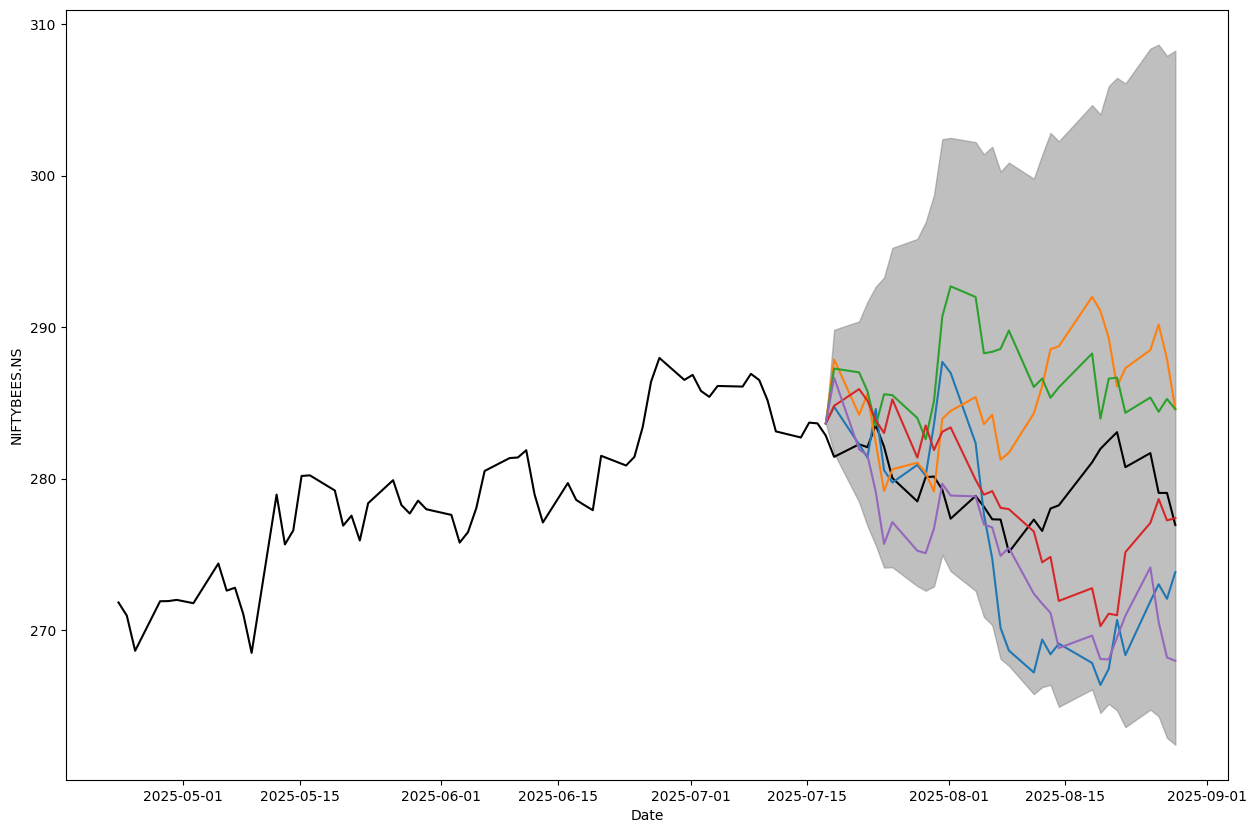

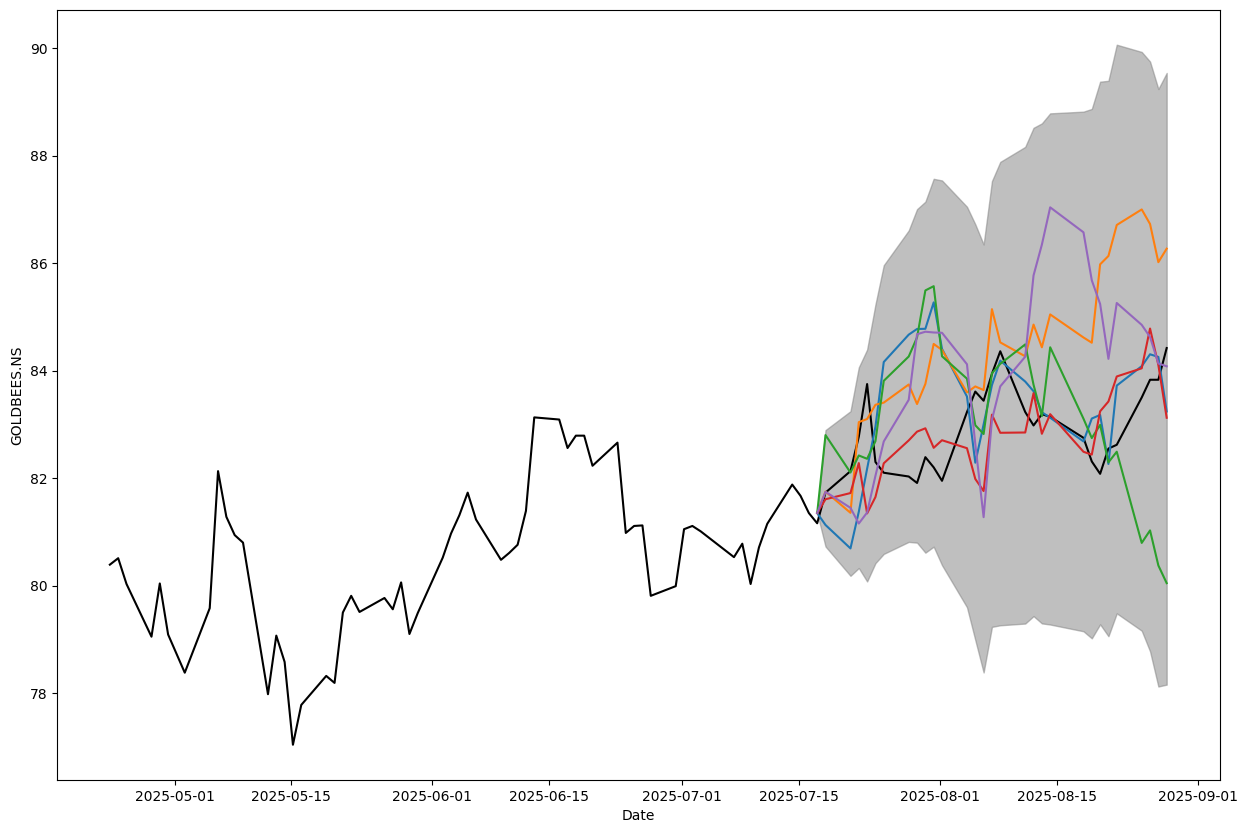

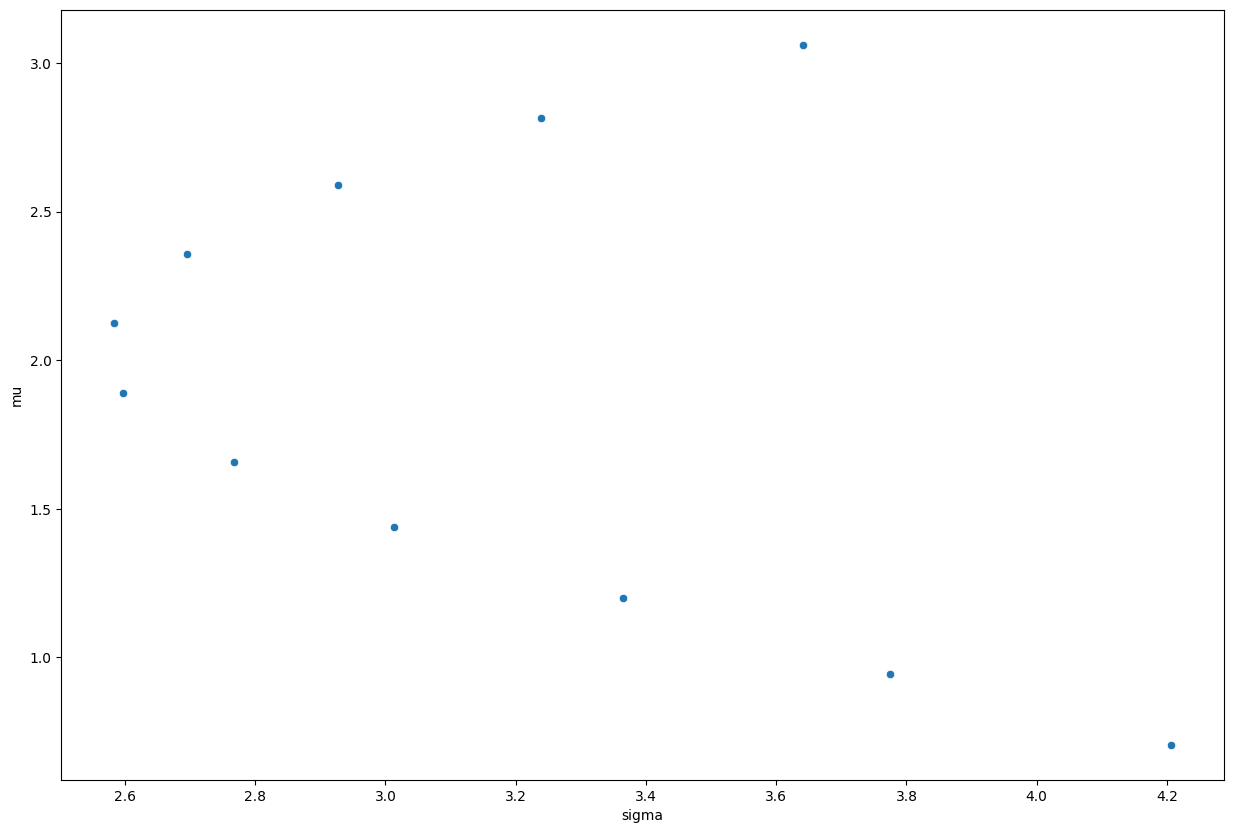

In [19]:
entity = {}
download_data(entity, ticker_list)
compute_daily_log_return(entity)
split_data(entity)
feature_engineering(entity)
fit_linear_model(entity)
compute_residue(entity)
compute_residual_variance(entity)
compute_residual_correlation(entity)
prepare_prediction_input(entity)
predict(entity)
generate_monte_carlo_path(entity)
forecast_price(entity)
compute_quartile(entity)
plot_mc_path(entity)
mu_sigma_plot(entity)